In [1]:
## El siguiente código combina RandomForest, XGBoost, y LogisticRegression como meta-estimador.


In [2]:
import dask.dataframe as dd
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import pandas as pd

In [3]:
# Cargar el DataFrame desde el archivo Parquet utilizando Dask
data_dd = dd.read_parquet(r'C:\Users\HOME\OneDrive - Universidad Nacional de Colombia\maestria_big_data\clases\TFM\codigo_TFM\data.parquet', engine='pyarrow')
X = data_dd['susceptibilidad'].compute().values.reshape(-1, 1)
y = data_dd['inventario'].compute()

# Dividir los datos en conjuntos de entrenamiento, validación y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2
gc.collect()

50

In [4]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

# Configurar SMOTE y undersampling con parámetros ajustados
smote = SMOTE(sampling_strategy=0.5, random_state=42)  # Ajusta el ratio a 0.5 para mayor equilibrio
under = RandomUnderSampler(sampling_strategy=0.7, random_state=42)  # Mantén una proporción razonable

# Crear pipeline con SMOTE seguido por undersampling
pipeline = Pipeline(steps=[('over', smote), ('under', under)])

# Aplicar el pipeline para balancear los datos de entrenamiento
X_train_resampled, y_train_resampled = pipeline.fit_resample(X_train, y_train)

print(f"After resampling, class distribution: {pd.Series(y_train_resampled).value_counts()}")


After resampling, class distribution: 0.0    6327
1.0    4429
Name: inventario, dtype: int64


In [5]:
# Definir modelos base
base_learners = [
    ('rf', RandomForestClassifier(random_state=42)),
    ('xgb', xgb.XGBClassifier(use_label_encoder=False, random_state=42)),
]

# Meta-estimador
meta_learner = LogisticRegression(max_iter=1000, random_state=42)

# Stacking ensemble
stack_model = StackingClassifier(
    estimators=base_learners,
    final_estimator=meta_learner,
    n_jobs=-1
)


In [6]:
# Definir parámetros para la búsqueda
param_grid = {
    'rf__n_estimators': [100, 200, 300],
    'rf__max_depth': [None, 10, 20],
    'rf__min_samples_split': [2, 5, 10],
    'rf__min_samples_leaf': [1, 2, 4],
    'rf__class_weight': ['balanced', {0: 1, 1: 5}, {0: 1, 1: 10}],
    'xgb__learning_rate': [0.01, 0.1, 0.2],
    'xgb__n_estimators': [50, 100, 200],
    'xgb__max_depth': [3, 6, 10],
    'xgb__scale_pos_weight': [1, len(y_train_resampled) / sum(y_train_resampled)],
}

# Configurar RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=stack_model,
    param_distributions=param_grid,
    n_iter=50,
    scoring='roc_auc',
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Ejecutar búsqueda
random_search.fit(X_train_resampled, y_train_resampled)

# Mostrar los mejores hiperparámetros encontrados
print("Best parameters found: ", random_search.best_params_)


Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best parameters found:  {'xgb__scale_pos_weight': 1, 'xgb__n_estimators': 50, 'xgb__max_depth': 3, 'xgb__learning_rate': 0.01, 'rf__n_estimators': 200, 'rf__min_samples_split': 5, 'rf__min_samples_leaf': 4, 'rf__max_depth': 10, 'rf__class_weight': {0: 1, 1: 10}}


In [7]:
# Mejor modelo obtenido
best_model = random_search.best_estimator_

# Ajustar umbral de decisión para mejorar el recall
def evaluate_model_threshold(model, X, y, threshold=0.5):
    y_pred_proba = model.predict_proba(X)[:, 1]
    y_pred = (y_pred_proba >= threshold).astype(int)
    accuracy = accuracy_score(y, y_pred)
    roc_auc = roc_auc_score(y, y_pred_proba)
    print(f'Accuracy: {accuracy}')
    print(f'ROC AUC: {roc_auc}')
    print(classification_report(y, y_pred))
    return y_pred

# Evaluar en validación
evaluate_model_threshold(best_model, X_val, y_val, threshold=0.4)

# Evaluar en prueba
evaluate_model_threshold(best_model, X_test, y_test, threshold=0.4)


Accuracy: 0.34866581956797965
ROC AUC: 0.4927715689626169
              precision    recall  f1-score   support

         0.0       0.74      0.19      0.31      2928
         1.0       0.25      0.80      0.39      1007

    accuracy                           0.35      3935
   macro avg       0.50      0.50      0.35      3935
weighted avg       0.61      0.35      0.33      3935

Accuracy: 0.3470528455284553
ROC AUC: 0.4962709414579205
              precision    recall  f1-score   support

         0.0       0.75      0.19      0.31      2955
         1.0       0.25      0.81      0.38       981

    accuracy                           0.35      3936
   macro avg       0.50      0.50      0.34      3936
weighted avg       0.63      0.35      0.33      3936



array([1, 0, 1, ..., 1, 1, 1])

Accuracy: 0.34866581956797965
ROC AUC: 0.4927715689626169
              precision    recall  f1-score   support

         0.0       0.74      0.19      0.31      2928
         1.0       0.25      0.80      0.39      1007

    accuracy                           0.35      3935
   macro avg       0.50      0.50      0.35      3935
weighted avg       0.61      0.35      0.33      3935



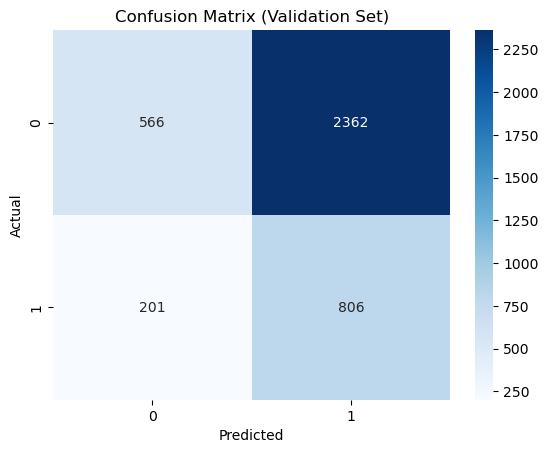

Accuracy: 0.3470528455284553
ROC AUC: 0.4962709414579205
              precision    recall  f1-score   support

         0.0       0.75      0.19      0.31      2955
         1.0       0.25      0.81      0.38       981

    accuracy                           0.35      3936
   macro avg       0.50      0.50      0.34      3936
weighted avg       0.63      0.35      0.33      3936



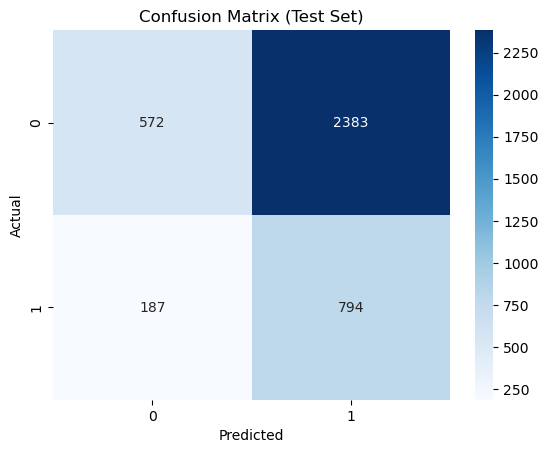

In [8]:
def plot_confusion_matrix(y_true, y_pred, title):
    conf_matrix = confusion_matrix(y_true, y_pred)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix ({title})')
    plt.show()

# Matriz de confusión para validación
y_val_pred = evaluate_model_threshold(best_model, X_val, y_val, threshold=0.4)
plot_confusion_matrix(y_val, y_val_pred, 'Validation Set')

# Matriz de confusión para prueba
y_test_pred = evaluate_model_threshold(best_model, X_test, y_test, threshold=0.4)
plot_confusion_matrix(y_test, y_test_pred, 'Test Set')
